In [1]:
#########################################################################
# 01. Libraries

import os
import pandas as pd
import numpy as np
import random
np.random.seed(12)

import seaborn as sns
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.decomposition import PCA

import time
import math
from tqdm import tqdm
from operator import itemgetter 

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras import regularizers as reg

import multiprocessing
import gc
# https://omoindrot.github.io/triplet-loss
# https://www.kaggle.com/sandy1112/create-and-train-resnet50-from-scratch - Good Generator

#########################################################################

In [2]:
#########################################################################
# 02. Load Data & Preprocess Data

# Train df

df_train = pd.read_csv('./train.csv')

print(df_train.shape)
print(f'1. -> There are {df_train.landmark_id.unique().shape[0]} unique landmarks')

# Images

train_paths = glob.glob('./train/*/*/*/*')
test_paths = glob.glob('./test/*/*/*/*')
index_paths = glob.glob('./index/*/*/*/*')

print(f'No. of Index Images : {len(index_paths)}')
print(f'No. of Train Images : {len(train_paths)}')
print(f'No. of Test Images : {len(test_paths)}')


# t=pd.DataFrame({"train_path":train_paths})
# t["id"]=t["train_path"].apply(lambda x: x.split("/")[-1][:-4])
# df_train=df_train.merge(t, how='inner',on=["id"])

# # Images Classes from: https://www.kaggle.com/sudeepshouche/identify-landmark-name-from-landmark-id

# url = 'https://s3.amazonaws.com/google-landmark/metadata/train_label_to_category.csv'
# dict_class = pd.read_csv(url, index_col = 'landmark_id', encoding='latin', engine='python')['category'].to_dict()

# # Only keep landmarks with 4 imgs or more

# series_groupby = df_train.groupby(['landmark_id'])['id'].count().sort_values()
# df_count_images_landmark = pd.DataFrame({
#     'landmark_id' : series_groupby.index,
#     'qt_images' : series_groupby.values
# })

# df_train = df_train.merge(df_count_images_landmark, how='inner')
# # df_train = df_train[df_train['qt_images']>=5]

# print(f'2. -> After filtering there are {df_train.landmark_id.unique().shape[0]} unique landmarks')

#########################################################################

(1580470, 2)
1. -> There are 81313 unique landmarks
No. of Index Images : 76176
No. of Train Images : 1580470
No. of Test Images : 1129


In [3]:
##########################################################################
# 03. Functions

# Plot imgs from an input landmark class in train folder

def printImg(class_id, df_landmarks, dict_class, figsize, max_rows=12, max_cols=3, img_size=(120, 120)):
    file_path = "./train/"
    df_landmarks = df_landmarks[df_landmarks['landmark_id'] == class_id].reset_index()
    
    print("Class {} - {}".format(class_id, dict_class[class_id].split(':')[-1]))
    print("Number of images: {}".format(len(df_landmarks)))
    
    plt.rcParams["axes.grid"] = False
    no_row = math.ceil(min(len(df_landmarks), max_rows)/max_cols) 
    f, axarr = plt.subplots(no_row, max_cols, figsize=figsize)

    curr_row = 0
    len_img = min(max_rows, len(df_landmarks))
    for i in range(len_img):
        img_name = df_landmarks['id'][i] + ".jpg"
        img_path = os.path.join(file_path, img_name[0], img_name[1], img_name[2], img_name)
        example = cv2.imread(img_path)
        example = cv2.resize(example, (img_size[0], img_size[1]), interpolation = cv2.INTER_AREA)
        # uncomment the following if u wanna rotate the image
        # example = cv2.rotate(example, cv2.ROTATE_180)
        example = example[:,:,::-1]

        col = i % 3
        axarr[curr_row, col].imshow(example)
        axarr[curr_row, col].set_title("{}. {} ({})".format(class_id, dict_class[class_id].split(':')[-1], df_landmarks['id'][i]))
        if col == 2:
            curr_row += 1
            
# Plot imgs from input folder {train, test, index}

def plotFolderImages(list_folder_imgs, max_imgs = 12):
    plt.rcParams["axes.grid"] = False
    f, axarr = plt.subplots(4, 3, figsize=(24, 22))

    curr_row = 0
    for i in range(max_imgs):
        example = cv2.imread(list_folder_imgs[i])
        # uncomment the following if u wanna rotate the image
        # example = cv2.rotate(example, cv2.ROTATE_180)
        example = example[:,:,::-1]

        col = i % 4
        axarr[col, curr_row].imshow(example)
        axarr[col, curr_row].set_title(list_folder_imgs[i])
        if col == 3:
            curr_row += 1
            
            
def decodeImage(filename, image_size=(240, 240), numpy=True):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)# / 255.0
    image = tf.image.resize(image, image_size)
    if numpy:
        return image.numpy()
    return image
            
            
##########################################################################

In [4]:
##########################################################################
# 04. Load preprocessed data

# thresh = 100 -> 90mins
df_train_preprocessed = pd.read_csv('./train_preprocessed_30imgs.csv')

df_train_preprocessed['train_path_local'] = df_train_preprocessed['train_path'].apply(lambda x: "./" + "/".join(x.split('/')[3:]))


##########################################################################

In [5]:
##########################################################################
# 05. Load model

# local_model = tf.saved_model.load('./model/') 
local_model = tf.keras.models.load_model('./models/model/')

##########################################################################

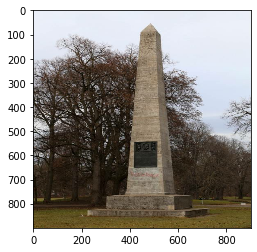

In [6]:
dict_id_to_path = df_train_preprocessed.set_index("id")["train_path_local"].to_dict()
dict_landmark_to_ids = df_train_preprocessed.groupby("landmark_id")["id"].apply(list).to_dict()
landmark = 7 

imgs = [decodeImage(dict_id_to_path[dict_landmark_to_ids[landmark][0]], (900, 900), numpy=True) for landmark in list(dict_landmark_to_ids.keys())[:6]] 
plt.imshow(imgs[0]/255)

In [7]:
##########################################################################
# 05. Classes

class SimilDataGenerator(Sequence):
    
    def __init__(self, df_train, batch_size, img_size_load=(250, 250, 3), img_size_crop=(224, 224, 3)):
        super().__init__()
        self.df_train = df_train
        self.batch_size = batch_size
        self.img_size_load = img_size_load
        self.img_size_crop = img_size_crop
        self.dict_id_to_landmark = self.df_train.set_index("id")["landmark_id"].to_dict()
        self.dict_landmark_to_ids = self.df_train.groupby("landmark_id")["id"].apply(list).to_dict()
        self.dict_id_to_path = self.df_train.set_index("id")["train_path_local"].to_dict()
        self.dict_landmark_to_count = self.df_train.set_index("landmark_id")["qt_images"].to_dict()
        
        self.ids = list(self.df_train['id'].unique())
        self.landmark_ids = set(self.df_train['landmark_id'].unique())
        self.dict_landmark_to_label = {value : i for i, value in enumerate(self.df_train['landmark_id'].unique())}
        self.on_epoch_end()
        self.num_steps = math.ceil(len(self.ids) / self.batch_size)
    # Number of batches in the sequence
    
    def __len__(self):
        return self.num_steps
#         return 1_000
    
    # Gets the batch at position index
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        ids = [self.ids[k] for k in indexes]
        X = [decodeImage(self.dict_id_to_path[id_], (self.img_size_load[0], self.img_size_load[1]), numpy=True) for id_ in ids]
        X = np.asarray([tf.image.random_crop(img, (self.img_size_crop[0], self.img_size_crop[1], 3)).numpy() for img in X])
        labels = np.asarray([self.dict_landmark_to_label[self.dict_id_to_landmark[id_]] for id_ in ids])
        y = np.zeros(len(ids))
        return (X, labels), labels
        
    
    # We shuffle the data at the end of each epoch
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        np.random.shuffle(self.indexes)

    
    
class GeMPoolingLayer(tf.keras.layers.Layer):
    
    def __init__(self, p=1., train_p=False):
        super().__init__(name='GeMPool')
        if train_p:
            self.p = tf.Variable(p, dtype=tf.float32)
        else:
            self.p = p
        self.eps = 1e-6

    def call(self, inputs: tf.Tensor, **kwargs):
        inputs = tf.clip_by_value(inputs, clip_value_min=1e-6, clip_value_max=tf.reduce_max(inputs))
        inputs = tf.pow(inputs, self.p)
        inputs = tf.reduce_mean(inputs, axis=[1, 2], keepdims=False)
        inputs = tf.pow(inputs, 1./self.p)
        return inputs


class AttentionModel(models.Model):
    """Instantiates attention model.
    Uses two [kernel_size x kernel_size] convolutions and softplus as activation
    to compute an attention map with the same resolution as the featuremap.
    Features l2-normalized and aggregated using attention probabilites as weights.
    """

    def __init__(self, kernel_size=1, decay=0.0001, name='attention'):
        """Initialization of attention model.
        Args:
          kernel_size: int, kernel size of convolutions.
          decay: float, decay for l2 regularization of kernel weights.
          name: str, name to identify model.
        """
        super(AttentionModel, self).__init__(name=name)

        # First convolutional layer (called with relu activation).
        self.conv1 = layers.Conv2D(
            512,
            kernel_size,
            kernel_regularizer=reg.l2(decay),
            padding='same',
            name='attn_conv1')
        self.bn_conv1 = layers.BatchNormalization(axis=3, name='bn_conv1')
        self.relu = layers.Activation('relu')
        
        # Second convolutional layer, with softplus activation.
        self.conv2 = layers.Conv2D(
            1,
            kernel_size,
            kernel_regularizer=reg.l2(decay),
            padding='same',
            name='attn_conv2')
        
        self.softplus = layers.Activation('softplus')

    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = self.bn_conv1(x, training=training)
        x = self.relu(x)

        score = self.conv2(x)
        prob = self.softplus(score)

        # L2-normalize the featuremap before pooling.
        inputs = tf.nn.l2_normalize(inputs, axis=-1)
        feat = tf.reduce_mean(tf.multiply(inputs, prob), [1, 2], keepdims=False)

        return feat, prob, score

    
class predictDataset(Sequence):
    def __init__(self, paths, batch_size, img_size_load, img_size_crop):
        self.paths=paths
        self.batch_size=batch_size
        self.img_size_load=img_size_load
        self.img_size_crop=img_size_crop
        self.on_epoch_end()
        
    def __len__(self,):
        return math.ceil(len(self.paths) / self.batch_size)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.paths))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        images=[self.paths[t] for t in indexes]
        images = [decodeImage(t, (self.img_size_load[0], self.img_size_load[1]), numpy=True) for t in images]
        images = [tf.image.random_crop(img, (self.img_size_crop[0], self.img_size_crop[1], 3)).numpy() for img in images]  
        return np.asarray(images)


def onlineTripletLoss(anchor_output, positive_output, negative_output, hard_neg=False, margin = 1.0):

#     anchor_output, positive_output, negative_output = y_pred[0], y_pred[1], y_pred[2]
    
    d_pos = tf.reduce_sum(tf.square(tf.subtract(anchor_output, positive_output)), 1)
    if hard_neg:
        d_neg = tf.reduce_min(tf.square(tf.subtract(anchor_output, negative_output)), 1)
    else:
        d_neg = tf.reduce_sum(tf.square(tf.subtract(anchor_output, negative_output)), 1)

    loss = tf.add(tf.subtract(d_pos, d_neg), margin)
    loss = tf.reduce_mean(tf.maximum(0.0, loss))
    
    return loss

class ImgEncoder(models.Model):
    
    def __init__(self, backbone, trainable=False):
        super(ImgEncoder, self).__init__(name='ImgEncoder')
        self.backbone = backbone.model
        layers_backbone = self.backbone.layers[1].layers[0].layers
        layers_backbone_train = [layer for layer in layers_backbone if layer.name.split('_')[0] != 'conv5']
        self.model = models.Model(inputs=layers_backbone_train[0].input, outputs=layers_backbone_train[-1].output)
        
        if trainable:
            self.model.trainable = True
        else:
            self.model.trainable = False
            
    def call(self, inputs):
        inputs = tf.keras.applications.resnet.preprocess_input(inputs)
        x = self.model(inputs)
        
        return x
    
    
class FeatureModel(models.Model):
    
    def __init__(self, backbone, num_classes, trainable=False):
        super(FeatureModel, self).__init__(name='FeatureModel')
        self.backbone = backbone.model
        self.num_classes = num_classes
        
        layers_backbone = self.backbone.layers[1].layers[0].layers
        self.model = models.Sequential(self.backbone.layers[1].layers[-4:-1])
        if trainable:
            self.model.trainable = True
        else:
            self.model.trainable = False
            
    def call(self, inputs):
        x = self.model(inputs)
        
        return x

    
class ArcFaceLayer(layers.Layer):
    def __init__(self, num_classes, margin, logit_scale):
        super().__init__()
        self.num_classes = num_classes
        self.margin = margin
        self.logit_scale = logit_scale

    def build(self, input_shape):
        self.w = self.add_weight("weights", shape=[int(input_shape[0][-1]), self.num_classes], initializer=tf.keras.initializers.get("glorot_normal"))
#         self.w = self.add_variable("weights", shape=[int(input_shape[-1]), self.num_classes])
        self.cos_m = tf.identity(tf.cos(self.margin), name='cos_m')
        self.sin_m = tf.identity(tf.sin(self.margin), name='sin_m')
        self.th = tf.identity(tf.cos(math.pi - self.margin), name='th')
        self.mm = tf.multiply(self.sin_m, self.margin, name='mm')

    def call(self, inputs, training=True, mask=None):
        embeddings, labels = inputs
        normed_embeddings = tf.nn.l2_normalize(embeddings, axis=1, name='normed_embd')
        normed_w = tf.nn.l2_normalize(self.w, axis=0, name='normed_weights')

        cos_t = tf.matmul(normed_embeddings, normed_w, name='cos_t')
        sin_t = tf.sqrt(1. - cos_t ** 2, name='sin_t')

        cos_mt = tf.subtract(cos_t * self.cos_m, sin_t * self.sin_m, name='cos_mt')

        cos_mt = tf.where(cos_t > self.th, cos_mt, cos_t - self.mm)

        mask = tf.one_hot(tf.cast(labels, tf.int32), depth=self.num_classes,
                          name='one_hot_mask')

        logits = tf.where(mask == 1., cos_mt, cos_t)
        logits = tf.multiply(logits, self.logit_scale, 'arcface_logist')
#         logits = tf.nn.softmax(logits)

        return logits
    
    
class DelfModel(models.Model):
    
    def __init__(self, img_encoder, feature_model, attention_model, num_classes):
        super(DelfModel, self).__init__(name='DelfModel')
        self.img_encoder = img_encoder
        self.feature_model = feature_model
        self.attention_model = attention_model
        
        self.num_classes = num_classes
        margin = 0.5 
        logit_scale = 64
        self.arcface = ArcFaceLayer(num_classes, margin, logit_scale)
    
    def call(self, inputs):
        images, labels = inputs
        x = self.img_encoder(images)
#         x1, probs, _ = self.attention_model(x)
        x2 = self.feature_model(x)
#         latent = tf.multiply(x1, x2)
        print(images.shape, labels.shape, x2.shape)
        x = self.arcface((x2, labels))
        print(labels.shape)
        print(x.shape)
        return x


class LandmarkRetrievalModel(tf.Module):
    def __init__(self, model, img_size):
        super(LandmarkRetrievalModel, self).__init__()
        self.model = model
        self.img_size = img_size
    
    @tf.function(input_signature=[
      tf.TensorSpec(shape=[None, None, 3], dtype=tf.uint8, name='input_image')
    ])
    
    def call(self, input_image):
        output_tensors = {}
        # Add batch dimension
        x = tf.expand_dims(input_image, 0, name='input_image')
        x = tf.image.resize(x, (self.img_size[0], self.img_size[1]))
        x = self.model(x)
        x = tf.squeeze(x, axis=0) #, name='encoding_flat')
        
        output_tensors['global_descriptor'] = tf.identity(x, name='global_descriptor')
        return output_tensors
    
##########################################################################

In [8]:
def softmaxLoss(y_true, y_pred):
    # y_true: sparse target
    # y_pred: logist
    y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    
    return tf.reduce_mean(loss)


class ModelTrainer:
    
    def __init__(self, delf_model, batch_size, epochs, X_generator):
        self.delf_model = delf_model
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.X_generator = X_generator
        self.loss = softmaxLoss # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = optimizers.Adam(0.001, beta_1=0.9, beta_2=0.995)   

    
    def getFinalModel(self):
        pass

    
    @tf.function
    def trainStep(self, list_img_tensor, target_tensor):
        batch_loss = 0

        with tf.GradientTape() as tape:
            predictions = self.delf_model(list_img_tensor)
            batch_loss += self.loss(target_tensor, predictions)
        

        trainable_variables = self.delf_model.trainable_variables
        gradients = tape.gradient(batch_loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        
        return batch_loss, predictions
    
    
    def fitModel(self):
        loss_plot = []
        for epoch in range(0, self.epochs):
            start = time.time()
            total_loss = 0

            for num_step, batch in enumerate(X_train_generator):
                list_img_tensor = batch[0]
                target_tensor = batch[1]
                batch_loss, predictions = self.trainStep(list_img_tensor, target_tensor)
                total_loss += batch_loss
#                 print(predictions)

                if num_step % 100 == 0:
#                     print(predictions[0])
                    print(f'Time in min:{(time.time() - start)/60} - Epoch - {epoch+1} - Batch - {num_step}/{self.X_generator.num_steps} - Loss - {np.sum(batch_loss)} ')
#                     print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target_tensor.shape[0])))
            
            # storing the epoch end loss value to plot later
            loss_plot.append(total_loss / num_step)

#             if epoch % 5 == 0:
#                 ckpt_manager.save()

            print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss))
            print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
        
##############################################################        
        
batch_size = 8
epochs = 1
img_size_load=(240, 240, 3)
img_size_crop=(220, 220, 3)
num_classes = df_train_preprocessed.landmark_id.unique().shape[0]

X_train_generator = SimilDataGenerator(df_train_preprocessed, batch_size=batch_size, img_size_load=img_size_load, 
                                       img_size_crop=img_size_crop)
                                                               
img_encoder = ImgEncoder(local_model, trainable=False)
feature_model = FeatureModel(local_model, num_classes, trainable=False)
attention_model = AttentionModel()
delf_model = DelfModel(img_encoder, feature_model, attention_model=attention_model, num_classes=num_classes)

trainer = ModelTrainer(delf_model, batch_size, epochs, X_train_generator)
trainer.fitModel()

##############################################################

(8, 220, 220, 3) (8,) (8, 1024)
(8,)
(8, 81313)
(8, 220, 220, 3) (8,) (8, 1024)
(8,)
(8, 81313)
tf.Tensor([ 3.288815  -2.374793   2.5629807 ...  1.9016993 -1.0791371  1.416381 ], shape=(81313,), dtype=float32)
Time in min:0.04691300789515177 - Epoch - 1 - Batch - 0/131287 - Loss - 43.349586486816406 
tf.Tensor([ 1.3713092  9.031979   6.557346  ...  6.9901648 14.907764   8.806136 ], shape=(81313,), dtype=float32)
Time in min:0.30708715120951335 - Epoch - 1 - Batch - 100/131287 - Loss - 55.68559265136719 
tf.Tensor([11.2313     8.135901   6.3999033 ...  9.213262   4.2018433  8.1973   ], shape=(81313,), dtype=float32)
Time in min:0.5673377354939778 - Epoch - 1 - Batch - 200/131287 - Loss - 60.71376419067383 
tf.Tensor(
[ -8.911718  -10.963064   -7.6880083 ... -10.711886  -18.718254
 -14.7973385], shape=(81313,), dtype=float32)
Time in min:0.8273195425669352 - Epoch - 1 - Batch - 300/131287 - Loss - 59.01549530029297 
tf.Tensor(
[ 0.16772652 -2.3918343  -3.4535875  ...  0.6224612   9.07057

tf.Tensor([-10.925414 -10.086203  -7.106798 ...  -9.090365 -16.069715 -12.118525], shape=(81313,), dtype=float32)
Time in min:7.091328767935435 - Epoch - 1 - Batch - 2700/131287 - Loss - 55.52423095703125 
tf.Tensor(
[-11.78767   -17.5826      1.0662911 ... -12.548455  -18.03104
 -12.734958 ], shape=(81313,), dtype=float32)
Time in min:7.352693128585815 - Epoch - 1 - Batch - 2800/131287 - Loss - 60.05696105957031 
tf.Tensor([-13.483055 -15.61665   -8.315437 ...  -9.771906 -17.654331 -13.028849], shape=(81313,), dtype=float32)
Time in min:7.614496533075968 - Epoch - 1 - Batch - 2900/131287 - Loss - 62.44960021972656 
tf.Tensor([-8.294363  -6.6279836  3.6841578 ... -9.533133   5.00054   -6.451766 ], shape=(81313,), dtype=float32)
Time in min:7.875605102380117 - Epoch - 1 - Batch - 3000/131287 - Loss - 60.32292938232422 
tf.Tensor([ 7.1751347  6.6633754 -3.1996355 ...  5.498227  -5.1882524  2.5198364], shape=(81313,), dtype=float32)
Time in min:8.136512879530589 - Epoch - 1 - Batch - 3100

tf.Tensor(
[ -5.5369787  -8.169027  -11.876007  ... -10.154247   -5.261917
   2.8103545], shape=(81313,), dtype=float32)
Time in min:23.30951960881551 - Epoch - 1 - Batch - 6600/131287 - Loss - 56.048973083496094 
tf.Tensor(
[ -6.166389  -10.004549   -8.6106205 ...  -6.9877205   3.0564995
  -5.5705934], shape=(81313,), dtype=float32)
Time in min:23.710607894261678 - Epoch - 1 - Batch - 6700/131287 - Loss - 55.995887756347656 
tf.Tensor(
[ -0.9840645  -9.637027   -3.512125  ... -12.50602    -8.677313
  -1.0619822], shape=(81313,), dtype=float32)
Time in min:24.10986998875936 - Epoch - 1 - Batch - 6800/131287 - Loss - 52.023773193359375 
tf.Tensor(
[  1.824255   -7.552122  -14.95761   ...   3.1801183 -17.075724
   0.695734 ], shape=(81313,), dtype=float32)
Time in min:24.50275566180547 - Epoch - 1 - Batch - 6900/131287 - Loss - 55.76925277709961 
tf.Tensor(
[-7.7340007e-03  2.1771598e+00 -9.5367985e+00 ...  1.1304883e+01
 -4.9944410e+00  1.0744396e+01], shape=(81313,), dtype=float32)
Tim

tf.Tensor(
[ -5.683718  -11.161928   -8.222351  ... -18.806166  -12.125837
  -7.0090218], shape=(81313,), dtype=float32)
Time in min:39.036905546983085 - Epoch - 1 - Batch - 10500/131287 - Loss - 54.11913299560547 
tf.Tensor(
[ -5.9195943  -9.600395   -8.371466  ...  -9.5210495   0.8694267
 -18.592237 ], shape=(81313,), dtype=float32)
Time in min:39.43630925019582 - Epoch - 1 - Batch - 10600/131287 - Loss - 49.5427131652832 
tf.Tensor(
[ -4.6281257   -3.629944    -4.524845   ... -11.256763     0.48644388
  -4.480969  ], shape=(81313,), dtype=float32)
Time in min:39.84476944208145 - Epoch - 1 - Batch - 10700/131287 - Loss - 53.51822280883789 
tf.Tensor([ 3.0527442  1.3591206  2.514388  ... -6.596299   3.8822174  6.0895796], shape=(81313,), dtype=float32)
Time in min:40.25454339981079 - Epoch - 1 - Batch - 10800/131287 - Loss - 53.16962432861328 
tf.Tensor(
[ -5.829901   -6.825034   -4.5834947 ...  -4.4149904 -11.370497
  -4.893253 ], shape=(81313,), dtype=float32)
Time in min:40.6609990

tf.Tensor([-5.1554265 -4.424591  -6.145714  ... -4.604895  -1.660704  -7.998114 ], shape=(81313,), dtype=float32)
Time in min:54.831723932425184 - Epoch - 1 - Batch - 14400/131287 - Loss - 48.12999725341797 
tf.Tensor(
[-0.85100055 -0.49039394 -2.8240383  ...  1.3463311  -2.7968125
 -2.9510574 ], shape=(81313,), dtype=float32)
Time in min:55.25328176816304 - Epoch - 1 - Batch - 14500/131287 - Loss - 48.070091247558594 
tf.Tensor(
[-13.232968  -13.954636  -13.923318  ...  -1.2655141 -13.750216
 -15.852101 ], shape=(81313,), dtype=float32)
Time in min:55.65642927885055 - Epoch - 1 - Batch - 14600/131287 - Loss - 49.23945999145508 
tf.Tensor(
[-12.068365  -12.569885  -11.796744  ...   4.6742654 -14.752267
 -14.23455  ], shape=(81313,), dtype=float32)
Time in min:56.06171307563782 - Epoch - 1 - Batch - 14700/131287 - Loss - 49.90915298461914 
tf.Tensor([-13.700073 -14.41341  -14.120474 ...  -9.646868 -10.978882 -13.556297], shape=(81313,), dtype=float32)
Time in min:56.468908747037254 - Ep

tf.Tensor([-23.156353 -25.315943 -23.078568 ... -22.903507 -22.976463 -23.014326], shape=(81313,), dtype=float32)
Time in min:71.0130075454712 - Epoch - 1 - Batch - 18400/131287 - Loss - 42.715614318847656 
tf.Tensor(
[ -9.226265  -10.38413    -9.158727  ...  -9.118914   -8.929244
  -9.1129055], shape=(81313,), dtype=float32)
Time in min:71.4140101035436 - Epoch - 1 - Batch - 18500/131287 - Loss - 42.25591278076172 
tf.Tensor([-6.4275236 -9.996029  -6.3551445 ... -6.3351827 -6.287904  -6.320731 ], shape=(81313,), dtype=float32)
Time in min:71.80987615982691 - Epoch - 1 - Batch - 18600/131287 - Loss - 41.59637451171875 
tf.Tensor([6.71562   5.5340667 6.849089  ... 6.713929  7.0012064 6.9078507], shape=(81313,), dtype=float32)
Time in min:72.2021030664444 - Epoch - 1 - Batch - 18700/131287 - Loss - 40.162139892578125 
tf.Tensor([-22.053143 -18.508148 -22.19819  ... -21.843784 -22.307764 -22.239662], shape=(81313,), dtype=float32)
Time in min:72.61012506087621 - Epoch - 1 - Batch - 18800/

tf.Tensor([-28.071747 -27.660114 -28.093777 ... -29.389658 -28.119854 -28.104576], shape=(81313,), dtype=float32)
Time in min:87.26000531514485 - Epoch - 1 - Batch - 22400/131287 - Loss - 37.65042495727539 
tf.Tensor([-16.308723 -16.068285 -16.342539 ... -16.619125 -16.391216 -16.36134 ], shape=(81313,), dtype=float32)
Time in min:87.66846460103989 - Epoch - 1 - Batch - 22500/131287 - Loss - 37.72599792480469 
tf.Tensor(
[-0.45643914 -0.49101162 -0.43848658 ...  0.14550346 -0.40549302
 -0.42695582], shape=(81313,), dtype=float32)
Time in min:88.07285927136739 - Epoch - 1 - Batch - 22600/131287 - Loss - 39.584861755371094 
tf.Tensor([14.511328 14.483694 14.516897 ... 15.158073 14.534446 14.522007], shape=(81313,), dtype=float32)
Time in min:88.48266557852428 - Epoch - 1 - Batch - 22700/131287 - Loss - 38.970481872558594 
tf.Tensor([-6.9380684 -6.829445  -6.929069  ... -6.382793  -6.9104953 -6.9228306], shape=(81313,), dtype=float32)
Time in min:88.89993111292522 - Epoch - 1 - Batch - 22

tf.Tensor([2.4629412 2.5033283 2.3258543 ... 4.9648957 2.4349701 1.4832916], shape=(81313,), dtype=float32)
Time in min:103.58498134215672 - Epoch - 1 - Batch - 26400/131287 - Loss - 40.715633392333984 
tf.Tensor([-21.865839 -21.715534 -21.891024 ... -20.572948 -21.894325 -19.929775], shape=(81313,), dtype=float32)
Time in min:104.00197480519613 - Epoch - 1 - Batch - 26500/131287 - Loss - 39.392242431640625 
tf.Tensor([-23.547977 -23.6083   -23.753796 ... -24.231232 -23.555363 -23.92628 ], shape=(81313,), dtype=float32)
Time in min:104.40988246997198 - Epoch - 1 - Batch - 26600/131287 - Loss - 39.28599548339844 
tf.Tensor([-36.392868 -36.41952  -36.338028 ... -35.109703 -36.381004 -37.407757], shape=(81313,), dtype=float32)
Time in min:104.81694612105687 - Epoch - 1 - Batch - 26700/131287 - Loss - 36.92665100097656 
tf.Tensor([-38.09687  -38.209137 -37.97338  ... -37.671364 -38.06079  -36.482452], shape=(81313,), dtype=float32)
Time in min:105.22254085540771 - Epoch - 1 - Batch - 26800

KeyboardInterrupt: 

In [ ]:
##########################################################################
# Model

# batch_size = 16
# epochs = 2
# img_size_load=(240, 240, 3)
# img_size_crop=(220, 220, 3)
# num_classes = df_train_preprocessed.landmark_id.unique().shape[0]

# X_train_generator = SimilDataGenerator(df_train_preprocessed, batch_size=batch_size, img_size_load=img_size_load, 
#                                        img_size_crop=img_size_crop)

# img_encoder = ImgEncoder(local_model, trainable=False)
# feature_model = FeatureModel(local_model, num_classes, trainable=False)
# attention_model = AttentionModel()

# ############################################


# delf_model = DelfModel(img_encoder, feature_model, attention_model=attention_model, num_classes=num_classes)
# delf_model.compile(loss=softmaxLoss, #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE), 
#                    optimizer=optimizers.Adam(0.001, beta_1=0.9, beta_2=0.995))

# # print(delf_model.summary())

# qt_processors = multiprocessing.cpu_count() # - 1

# history = delf_model.fit(
#     X_train_generator,
# #   use_multiprocessing=False,
#     workers=qt_processors,
#     epochs=epochs,
#     verbose=1
# ) 

##########################################################################

In [ ]:
# 461/16411 [..............................] - ETA: 11:40:27 - loss: 0.3499
# 4364/16411 [======>.......................] - ETA: 7:56:35 - loss: 0.2804 # p = 3
# 7982/16411 [=============>................] - ETA: 5:20:43 - loss: 0.2572
# 11657/16411 [====================>.........] - ETA: 3:11:28 - loss: 0.2517

##########################################################################

In [ ]:
X_train_generator = SimilDataGenerator(df_train_preprocessed, batch_size=8, img_size_load=(900, 900, 3), 
                                       img_size_crop=(720, 720, 3))

for batch in X_train_generator:
    img_tensor = batch[0]
    target_tensor = batch[1]
    print(len(img_tensor), img_tensor[0].shape, target_tensor.shape)
    break

In [ ]:
inputs, labels = batch[0]
labels.shape

In [ ]:
X_train_generator = SimilDataGenerator(df_train_preprocessed, batch_size=4, img_size_load=(900, 900, 3), 
                                       img_size_crop=(720, 720, 3))
print('Generator created')
for batch in X_train_generator:
    break
print(len(batch))
print(batch[0].shape)
print(batch[1].shape)
plt.imshow(batch[0][1, :, :, :]/255)
plt.show()

In [ ]:
import scipy

dict_landmark_to_ids = df_train_preprocessed.groupby("landmark_id")["id"].apply(list).to_dict()
dict_id_to_path = df_train_preprocessed.set_index("id")["train_path_local"].to_dict()

landmark = np.random.choice(list(dict_landmark_to_ids.keys()))

query_img1 = decodeImage(dict_id_to_path[dict_landmark_to_ids[landmark][0]], (img_size_crop[0], img_size_crop[1]), numpy=True)
query_img2 = decodeImage(dict_id_to_path[dict_landmark_to_ids[landmark][1]], (img_size_crop[0], img_size_crop[1]), numpy=True)
query_img3 = decodeImage(train_paths[2], (img_size_crop[0], img_size_crop[1]), numpy=True)
query_img4 = decodeImage(train_paths[4], (img_size_crop[0], img_size_crop[1]), numpy=True)


emb1 = embedding_model.predict(np.expand_dims(query_img1, axis=0))
emb2 = embedding_model.predict(np.expand_dims(query_img2, axis=0))
emb3 = embedding_model.predict(np.expand_dims(query_img3, axis=0))
emb4 = embedding_model.predict(np.expand_dims(query_img4, axis=0))

f, axarr = plt.subplots(2, 2, figsize=(22, 20))
imgs = [query_img1, query_img2, query_img3, query_img4]
curr_row = 0
for i in range(4):
    col = i % 2
    axarr[col, curr_row].imshow(imgs[i]/255)
    axarr[col, curr_row].set_title(i+1)
    if i==1:
        curr_row+=1
    
print(f'Distance 1-2: {scipy.spatial.distance.euclidean(emb1, emb2)}')
print(f'Distance 1-3: {scipy.spatial.distance.euclidean(emb1, emb3)}')
print(f'Distance 1-4: {scipy.spatial.distance.euclidean(emb1, emb4)}')


# print(f'Distance 1-2: {scipy.spatial.distance.euclidean(tf.math.l2_normalize(emb1), tf.math.l2_normalize(emb2))}')
# print(f'Distance 1-3: {scipy.spatial.distance.euclidean(tf.math.l2_normalize(emb1), tf.math.l2_normalize(emb3))}')
# print(f'Distance 1-4: {scipy.spatial.distance.euclidean(tf.math.l2_normalize(emb1), tf.math.l2_normalize(emb4))}')

In [ ]:
#######################################################################
# Evaluating the model
# Knn

# X_test_generator=predictDataset(test_paths, batch_size=32, img_size=img_size)
X_index_generator = predictDataset(index_paths, batch_size=64, img_size_load=img_size_load, 
                                       img_size_crop=img_size_crop)

# # query_embeddings = embedding_model.predict(X_test_generator)
index_embeddings = embedding_model.predict(X_index_generator)
# index_embeddings = tf.math.l2_normalize(index_embeddings).numpy()

knn = NearestNeighbors(n_neighbors=100, metric="euclidean")
knn.fit(index_embeddings)
indexes = [12, 78, 150, 200, 341, 679, 77<1, 897, 917, 999, 1098, 1128]

for query_index in indexes:
    query_img = decodeImage(test_paths[query_index], (img_size_crop[0], img_size_crop[1]), numpy=True)
    query_embedding = embedding_model.predict(np.expand_dims(query_img, axis=0))
#     query_embedding = tf.math.l2_normalize(query_embedding).numpy()
    distances, indices = knn.kneighbors(query_embedding)
    print('Query image: ')
    plt.imshow(query_img/255)
    plt.show()
    print('1 - Match index: ')
    print(f'Distance={distances.squeeze()[0]}')
    plt.imshow(decodeImage(index_paths[indices.squeeze()[0]])/255)
    plt.show()
    print('2 - Match index: ')
    print(f'Distance={distances.squeeze()[1]}')
    plt.imshow(decodeImage(index_paths[indices.squeeze()[1]])/255)
    plt.show()
    print('3 - Match index: ')
    print(f'Distance={distances.squeeze()[2]}')
    plt.imshow(decodeImage(index_paths[indices.squeeze()[2]])/255)
    plt.show()

#######################################################################

In [ ]:
#######################################################################
# Submission

from zipfile import ZipFile

lr_model = LandmarkRetrievalModel(embedding_model, img_size_crop)
tf.saved_model.save(lr_model, './models/att_model', signatures={"serving_default" : lr_model.call})


with ZipFile('att_submission.zip','w') as output_zip_file:
    for filename in os.listdir('./models/att_model'):
        if os.path.isfile('./models/att_model/'+filename):
            output_zip_file.write('./models/att_model/'+filename, arcname=filename) 
    for filename in os.listdir('./models/att_model/variables'):
        if os.path.isfile('./models/att_model/variables/'+filename):
            output_zip_file.write('./models/att_model/variables/'+filename, arcname='variables/'+filename)
    for filename in os.listdir('./models/att_model/assets'):
        if os.path.isfile('./att_model/assets/'+filename):
            output_zip_file.write('./models/att_model/assets/'+filename, arcname='assets/'+filename)
            
#######################################################################